# Image Classifier for Sumthing.org

Author: Gent Thaqi | gjentig4@gmail.com

## Introduction

Welcome to the Image Classifier project! This Jupyter Notebook details a machine learning solution developed for Sumthing.org. The NGO, dedicated to environmental conservation, needed a tool to automatically sort batches of images into two categories: 'trees' and 'plastic'. This classification aids in documenting and showcasing their efforts in tree planting and garbage collection to donors and the public.

## Project Objective

- **Aim**: To develop an automated image classifier for efficiently sorting images into 'trees' and 'plastic'.
- **Benefit**: Streamlines image management and enhances the presentation of the NGO's environmental initiatives.

## Approach

- **Method**: Utilized TensorFlow and Keras to build a neural network, adopting the MobileNetV2 model with transfer learning.
- **Outcome**: Achieved a remarkable 100% accuracy in image classification, showcasing the model's efficiency and reliability.

## Application

- The classifier processes images sourced from local storage or AWS S3 buckets.
- Post-classification, the images are sorted into designated folders on AWS S3, simplifying access and documentation.

## Impact

- The model significantly aids in managing large image datasets.
- Provides a visual record of the NGO's impactful work, boosting transparency and donor engagement.

## Conclusion

This project exemplifies the application of machine learning in environmental conservation, offering a practical solution to a real-world challenge faced by Sumthing.org.



Feel free to explore the code and reach out for any queries or collaborations on similar projects!


In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle


In [2]:
# Set the paths to the directories
input_dir = "/kaggle/input/sumting-1"        # Directory where the data is stored
trees_dir = os.path.join(input_dir, 'trees/trees')    # Subdirectory containing tree images
plastic_dir = os.path.join(input_dir, 'plastic/plastic')    # Subdirectory containing plastic images

# Create data generators
datagen = ImageDataGenerator(
    rescale=1./255,           # Rescale pixel values to range 0-1 for normalization
    horizontal_flip=True,     # Randomly flip images horizontally
    vertical_flip=True,       # Randomly flip images vertically
    rotation_range=20,        # Randomly rotate images up to 20 degrees
    zoom_range=0.2,           # Randomly zoom images up to 20%
    width_shift_range=0.2,    # Randomly shift images horizontally up to 20%
    height_shift_range=0.2,   # Randomly shift images vertically up to 20%
    validation_split=0.2      # Split the data into training and validation sets, with 20% used for validation
)

# Define the generator for training data
train_generator = datagen.flow_from_directory(
    input_dir,                       # Directory where the data is stored
    classes=['trees', 'plastic'],    # List of subdirectories containing the class-specific images
    target_size=(224, 224),          # Resize images to 224 x 224 pixels
    batch_size=32,                   # Generate batches of 32 images at a time
    class_mode='binary',             # The problem is binary classification
    subset='training',               # Use a subset of the data for training
    shuffle=True,                    # Shuffle the data before each epoch
    seed=42                          # Set a random seed for reproducibility
)

# Define the generator for validation data
val_generator = datagen.flow_from_directory(
    input_dir,                       # Directory where the data is stored
    classes=['trees', 'plastic'],    # List of subdirectories containing the class-specific images
    target_size=(224, 224),          # Resize images to 224 x 224 pixels
    batch_size=32,                   # Generate batches of 32 images at a time
    class_mode='binary',             # The problem is binary classification
    subset='validation',             # Use the remaining data for validation
    shuffle=True,                    # Shuffle the data before each epoch
    seed=42                          # Set a random seed for reproducibility
)


Found 981 images belonging to 2 classes.
Found 244 images belonging to 2 classes.


In [3]:
# Load the pre-trained model
base_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')

# Freeze the base model
for layer in base_model.layers:
    layer.trainable = False       # Set each layer in the pre-trained model to non-trainable

# Add custom layers
x = base_model.output
x = GlobalAveragePooling2D()(x)        # Apply global average pooling to reduce the number of features
x = Dense(256, activation='relu')(x)   # Add a fully connected layer with 256 neurons and ReLU activation
x = Dropout(0.5)(x)                    # Add dropout regularization to prevent overfitting
predictions = Dense(1, activation='sigmoid')(x)   # Add a final output layer with a sigmoid activation function for binary classification

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)   # Create a new model by specifying the input and output layers

# Compile the model
model.compile(optimizer=Adam(lr=0.001), loss='binary_crossentropy', metrics=['accuracy'])   # Set the optimizer, loss function, and evaluation metric for the model


9406464/9406464 [==============================] - 1s 0us/step


In [4]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    validation_data=val_generator,
    validation_steps=len(val_generator),
    epochs=10
)


Epoch 1/10
31/31 [==============================] - 87s 3s/step - loss: 0.1285 - accuracy: 0.9501 - val_loss: 0.0731 - val_accuracy: 0.9713
Epoch 2/10
31/31 [==============================] - 76s 2s/step - loss: 0.0071 - accuracy: 0.9980 - val_loss: 0.0065 - val_accuracy: 1.0000
Epoch 3/10
31/31 [==============================] - 72s 2s/step - loss: 0.0067 - accuracy: 0.9980 - val_loss: 0.0043 - val_accuracy: 1.0000
Epoch 4/10
31/31 [==============================] - 75s 2s/step - loss: 0.0119 - accuracy: 0.9990 - val_loss: 0.0064 - val_accuracy: 1.0000
Epoch 5/10
31/31 [==============================] - 72s 2s/step - loss: 0.0014 - accuracy: 1.0000 - val_loss: 0.0030 - val_accuracy: 1.0000
Epoch 6/10
31/31 [==============================] - 72s 2s/step - loss: 0.0077 - accuracy: 0.9969 - val_loss: 0.0062 - val_accuracy: 1.0000
Epoch 7/10
31/31 [==============================] - 75s 2s/step - loss: 0.0055 - accuracy: 0.9990 - val_loss: 0.0210 - val_accuracy: 0.9918
Epoch 8/10
31/31 [==

In [5]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt



In [6]:
# Get the ground truth labels from the validation generator
y_true = val_generator.classes[val_generator.index_array]

# Make predictions
predictions = model.predict(val_generator, steps=len(val_generator))
y_pred = np.round(predictions).reshape(-1)

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred)


8/8 [==============================] - 18s 2s/step


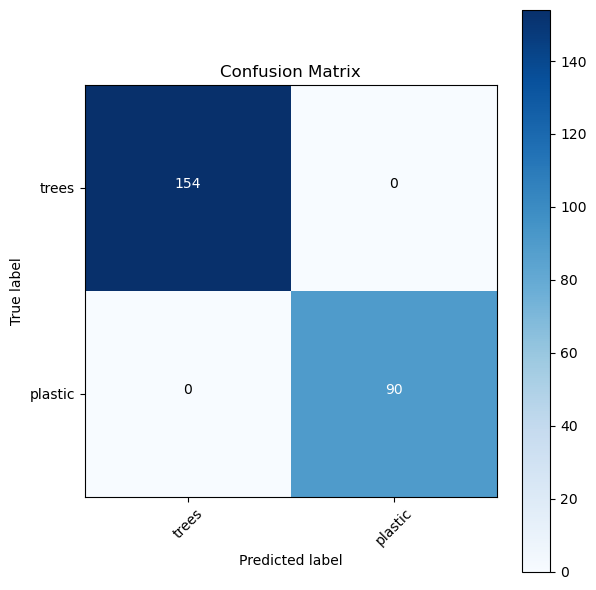

In [7]:
import itertools
# Function to visualize the confusion matrix
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix', cmap=plt.cm.Blues):
    plt.figure(figsize=(6, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.0
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

# Plot the confusion matrix
plot_confusion_matrix(cm, ['trees', 'plastic'])


In [8]:
# Print the classification report
print(classification_report(y_true, y_pred, target_names=['trees', 'plastic']))


              precision    recall  f1-score   support

       trees       1.00      1.00      1.00       154
     plastic       1.00      1.00      1.00        90

    accuracy                           1.00       244
   macro avg       1.00      1.00      1.00       244
weighted avg       1.00      1.00      1.00       244



### Trees

1/1 [==============================] - 0s 48ms/step


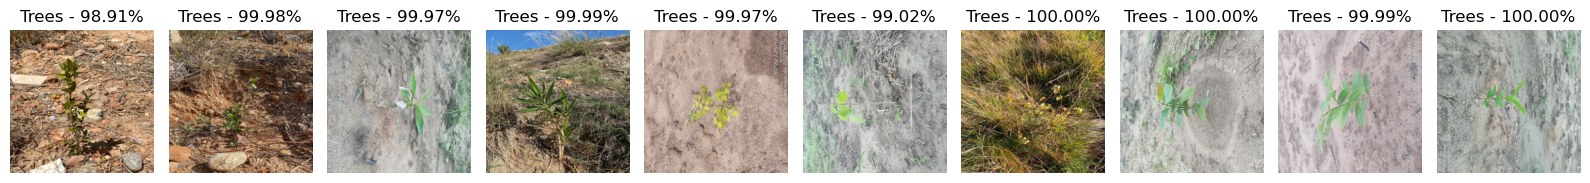

### Plastic

1/1 [==============================] - 0s 50ms/step


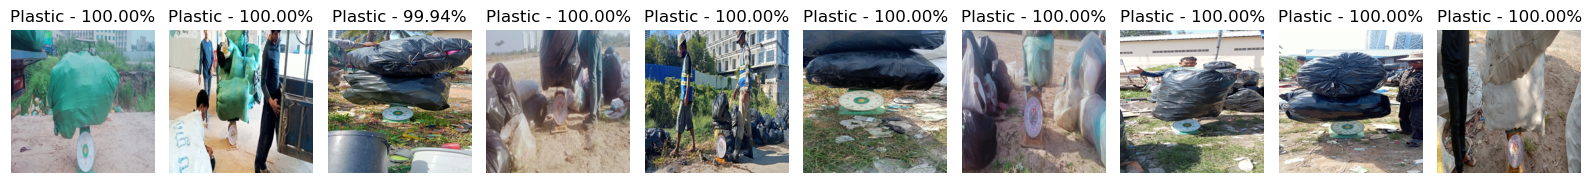

In [12]:
import random
from IPython.display import Markdown
from PIL import Image

# Sample images from each class
sample_trees = random.sample(os.listdir(trees_dir), 10)
sample_plastic = random.sample(os.listdir(plastic_dir), 10)

# Function to display images with their predicted probabilities
def display_images_with_probabilities(images, true_label, base_dir):
    fig, axes = plt.subplots(1, len(images), figsize=(16, 4))
    for idx, image_file in enumerate(images):
        img_path = os.path.join(base_dir, true_label, image_file)
        img = Image.open(img_path)
        img_resized = img.resize((224, 224))
        img_array = np.array(img_resized) / 255.0
        img_expanded = np.expand_dims(img_array, axis=0)
        
        prediction = model.predict(img_expanded)[0][0]
        if true_label == "trees":
            prediction_percentage = (1 - prediction) * 100
        else:
            prediction_percentage = prediction * 100
        
        axes[idx].imshow(img_resized)
        axes[idx].set_title(f"{true_label.capitalize()} - {prediction_percentage:.2f}%")
        axes[idx].axis('off')
    plt.tight_layout()
    plt.show()

# Display images with their predicted probabilities
display(Markdown("### Trees"))
display_images_with_probabilities(sample_trees, "trees", os.path.join(input_dir, 'trees'))
display(Markdown("### Plastic"))
display_images_with_probabilities(sample_plastic, "plastic", os.path.join(input_dir, 'plastic'))


In [26]:
# Save the model
model.save('plastic_classification_model.h5')


In [27]:
from IPython.display import FileLink

FileLink('plastic_classification_model.h5')


/kaggle/working/plastic_classification_model.h5